## 1. Function and analytical gradient

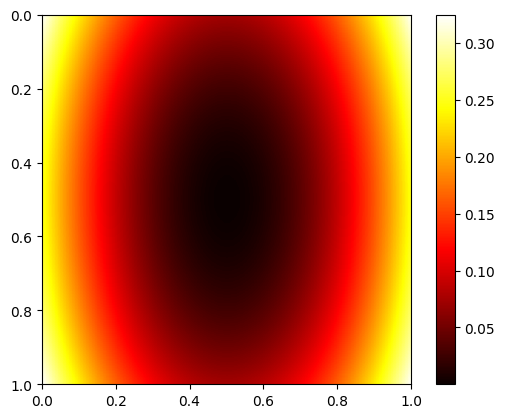

In [19]:
import torch
import utils
import math
from utils import get_acceleration_right_triangle_slope, convert_slope_to_angle, get_acceleration_right_triangle, G, get_grads, f_paraboloid, f_grad


H = W = 500 # [0, 1]

ys = torch.linspace(0, 1, H)
xs = torch.linspace(0, 1, W)
X, Y = torch.meshgrid(xs, ys, indexing="xy")

Z = f_paraboloid(X, Y)
utils.print_tensor(Z)

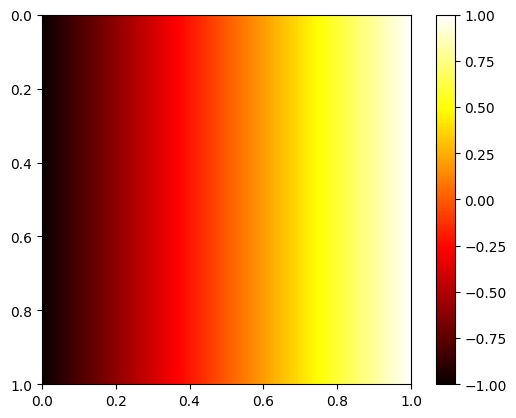

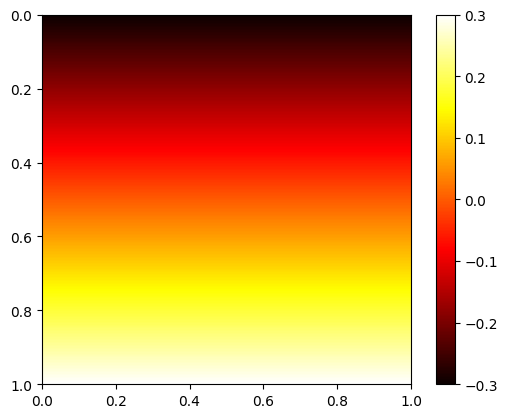

In [20]:
# let Z := f : (x, y) -> z, where x, y in [0, 1] (m)
x_grad, y_grads = f_grad(X, Y)
utils.print_tensor(x_grad)
utils.print_tensor(y_grads)


# 2. Checking we can estimate this analytical gradient

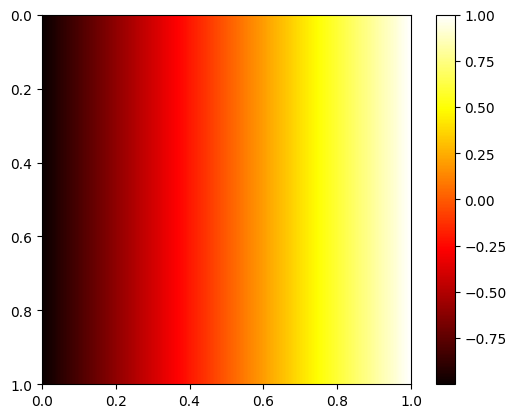

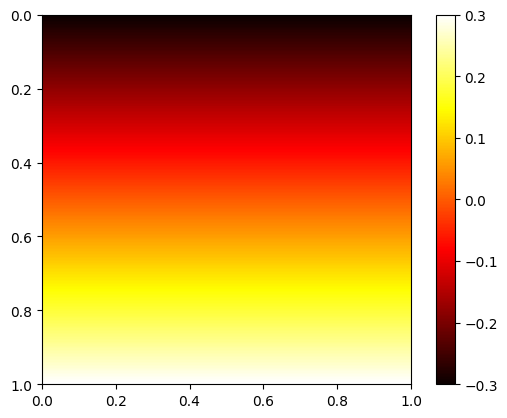

In [21]:
gradient_x, gradient_y = get_grads(Z, H=500, W=500)
utils.print_tensor(gradient_x)
utils.print_tensor(gradient_y)

# 3. get components of acceleration

In [22]:
theta = torch.tensor(0.001)
x, y, z = get_acceleration_right_triangle(theta)
assert torch.allclose(z, -G * torch.sin(theta))

In [23]:
assert torch.allclose(convert_slope_to_angle(torch.tensor(1)), torch.tensor(math.pi / 4))

In [24]:
# a flat right triangle has no acceleration
get_acceleration_right_triangle_slope(torch.tensor(0))

(tensor(-0.), tensor(-0.), tensor(0.))

In [25]:
# vertical right triangle has 100% g in y direction
get_acceleration_right_triangle_slope(torch.tensor(float("inf")))

(tensor(4.3711e-14), tensor(-1.0000e-06), tensor(1.0000e-06))

# 4. Assume a slice along y=0 (1D solution)

In [26]:
x_0 = torch.tensor(0.7)
v_x_0 = torch.tensor(0.0)
x_slope, _ = f_grad(x_0, torch.tensor(0.0))
x_slope

tensor(0.4000)

In [27]:
acc_at_point = get_acceleration_right_triangle_slope(x_slope)
acc_at_point

(tensor(-3.4483e-07), tensor(-1.3793e-07), tensor(3.7139e-07))

In [28]:
# update position
x_acc, height, mag = acc_at_point
v_x_0 += x_acc
x_0 += v_x_0
x_0

tensor(0.7000)

In [29]:
def get_updated_pos(x_i: torch.Tensor, v_i: torch.Tensor, x_slope: torch.Tensor):
    x_acc_comp, _, _ = get_acceleration_right_triangle_slope(x_slope)
    v_i_1 = v_i + x_acc_comp
    x_i_1 = x_i + v_i_1
    return x_i_1

get_updated_pos(torch.tensor(0.7), torch.tensor(0), torch.tensor(0.4))

tensor(0.7000)

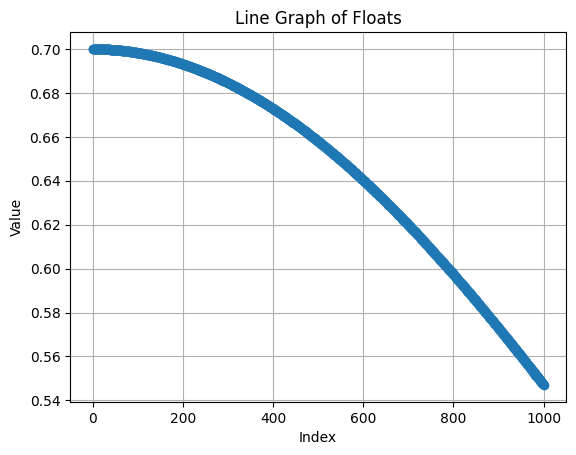

In [30]:
ITERATIONS = 1000

x_i = torch.tensor(0.7)
v_i = torch.tensor(0.0)
values = [float(x_i)]
for _ in range(ITERATIONS):
    _slope, _ = f_grad(x_i, torch.tensor(0.0))
    x_acc_comp, _, _ = get_acceleration_right_triangle_slope(_slope)
    # print(float(x_acc_comp)) # this is parabolic so we expect this to change right?
    v_i += x_acc_comp
    x_i += v_i
    if x_i < 0.0:
        x_i += 1.0
    if x_i > 1.0:
        x_i -= 1.0
    values.append(float(x_i))

utils.print_list_numbers(numbers=values) # their x-component value

## 5. Do the same for 2D slice - ball moving

In [31]:
# Initial parameters
NUM_ITER = 1000*2*5*3
position_of_ball = torch.tensor([0.1, 0.1])
velocity = torch.tensor([0.0, 0.0])

position_over_iterations = [position_of_ball.clone()]
velocity_mag_over_time = [torch.norm(velocity, p=2)]
for _ in range(NUM_ITER):
    x_slope, y_slope = f_grad(position_of_ball[0], position_of_ball[1])
    x_acc_comp, _, _ = get_acceleration_right_triangle_slope(x_slope)
    y_acc_comp, _, _, = get_acceleration_right_triangle_slope(y_slope)
    acceleration = torch.stack((x_acc_comp, y_acc_comp))
    velocity += acceleration
    position_of_ball += velocity
    position_over_iterations.append(position_of_ball.clone())
    velocity_mag_over_time.append(torch.norm(velocity, p=2))

position_over_iterations = torch.stack(position_over_iterations)
velocity_mag_over_time = torch.stack(velocity_mag_over_time) * 90
print(velocity_mag_over_time)



tensor([0.0000e+00, 4.8421e-05, 9.6841e-05,  ..., 2.5332e-02, 2.5372e-02,
        2.5412e-02])


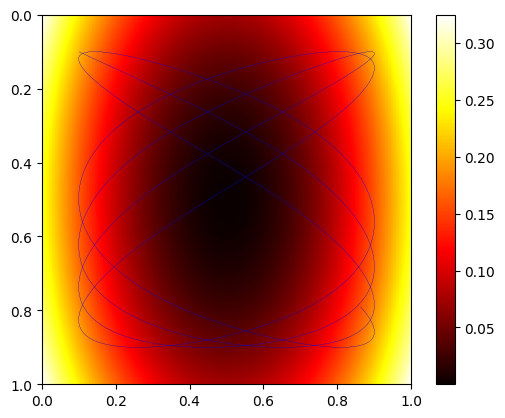

In [32]:
utils.print_tensor(Z, position_over_iterations, ball_sizes=velocity_mag_over_time)

In [33]:
# idea, todo: ball distance not linked to speeds (fixed step size)

## Now do it using estimates

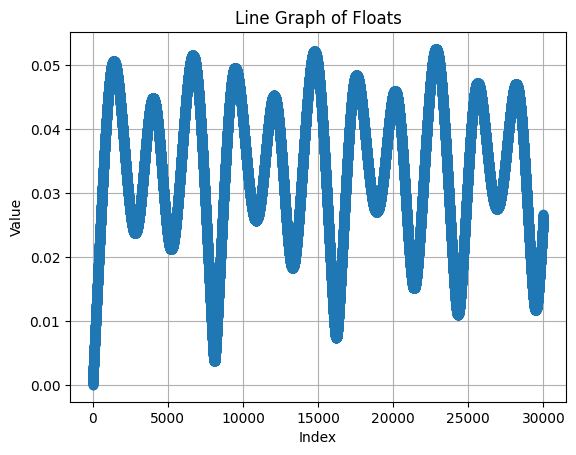

In [34]:
# Initial parameters
NUM_ITER = 1000*2*5*3
position_of_ball = torch.tensor([0.1, 0.1])
velocity = torch.tensor([0.0, 0.0])
position_over_iterations = [position_of_ball.clone()]
velocity_mag_over_time = [torch.norm(velocity, p=2)]

x_slopes, y_slopes = get_grads(Z, H, W)
def get_at_x_y(x, y):
    coords = int(y * W), int(x * H)
    return x_slopes[*coords], y_slopes[*coords]

for i in range(NUM_ITER):
    x_slope, y_slope = get_at_x_y(position_of_ball[0], position_of_ball[1])
    x_acc_comp, _, _ = get_acceleration_right_triangle_slope(x_slope)
    y_acc_comp, _, _, = get_acceleration_right_triangle_slope(y_slope)
    acceleration = torch.stack((x_acc_comp, y_acc_comp))
    velocity += acceleration
    position_of_ball += velocity
    position_over_iterations.append(position_of_ball.clone())
    velocity_mag_over_time.append(torch.norm(velocity, p=2))

position_over_iterations = torch.stack(position_over_iterations)
velocity_mag_over_time = torch.stack(velocity_mag_over_time) * 90
utils.print_list_numbers(list(velocity_mag_over_time))



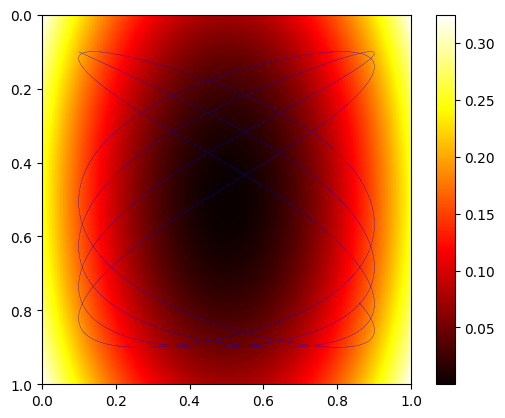

In [38]:
utils.print_tensor(Z, position_over_iterations, ball_sizes=velocity_mag_over_time)

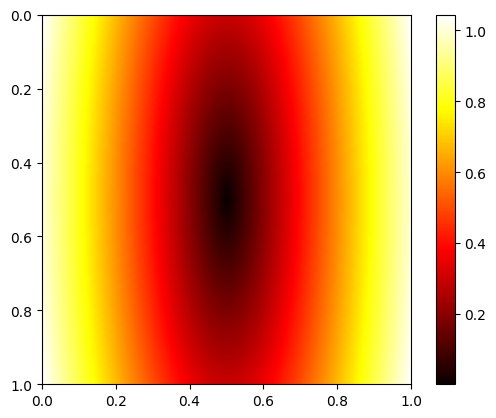

In [39]:
utils.print_tensor(torch.sqrt(x_slopes ** 2 + y_slopes ** 2))